---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle
import numpy as np
# TODO: Fill this in based on where you saved the training and testing data

training_file = 'data/pkl_data/train.p'
testing_file = 'data/pkl_data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
x_train, y_train = train['features'], train['labels']
x_test, y_test = test['features'], test['labels']

print('Reading data done!')

Reading data done!


In [2]:
### Replace each question mark with the appropriate value.
import numpy as np
# TODO: Number of training examples
n_train = len(y_train)

# TODO: Number of testing examples.
n_test = len(y_test)

# TODO: What's the shape of an traffic sign image?
image_shape = x_train.shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(np.append(y_train,y_test)))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (34799, 32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

9


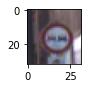

In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import random
import numpy as np
# Visualizations will be shown in the notebook.
%matplotlib inline

index = random.randint(0,len(x_train))
image = x_train[index].squeeze()

plt.figure(figsize=(1,1))
plt.imshow(image)
print(y_train[index])

Text(0.5, 1.0, 'histogram before data preprocessing')

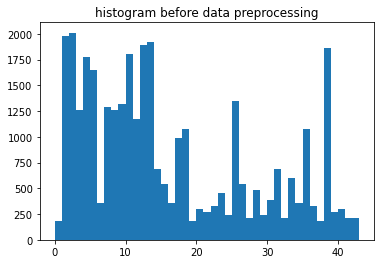

In [4]:
# Visulization of the histogram
images_per_class, bins, _ = plt.hist(y_train,bins=range(n_classes+1))
plt.title('histogram before data preprocessing')

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test model on the [German Traffic Sign Dataset]

In [5]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

# 1. rgb to grayscale 
# 2. apply histogram equalization
# 3. normalize the training and testing data to [-1 1]
import cv2
def grayAndEqualizeHist(img):
    """

    :param img: input RGB image
    :return: histogram equalized grayscale image
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY )
    equ  = cv2.equalizeHist(gray)
    #equ  = equ - 128. / 128.
    return equ


x_train = np.array([grayAndEqualizeHist(img) for img in x_train])
x_test = np.array([grayAndEqualizeHist(img) for img in x_test])

print('preprocessed the data')
# print(x_train)

preprocessed the data


In [6]:
# Generate additional data


Visulization of one image: before and after similarity transform


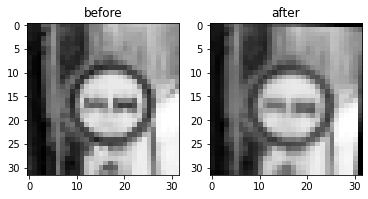

In [7]:
# 2. generate more images with a random similarity transform (2x3 matrix)
import random
import math
import cv2

def applyRandSimilarityTran(image, n):
    """ 
        apply random similarity transformation to the image, and return
        n transformed images
    """
    output_images = np.zeros((n,32,32))

    for i in range(n):
        angle = random.uniform(-15, 15) # rotation

        s = random.uniform(0.7, 1.3)    # scale

        rows,cols = image.shape[0:2]
        image_center = (rows/2.0, cols/2.0)
        rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1)
        M_rot = np.vstack([rot_mat,[0,0,1]])

        tx = random.uniform(-2, 2)      # translation along x axis
        ty = random.uniform(-2, 2)      # translation along y axis
        M_tran = np.float32([[1,0,tx],[0,1,ty],[0,0,1]])

        M = np.matrix(M_tran) * np.matrix(M_rot)

        M = np.float32(M[:2][:]) # similarity transform

        tmp = cv2.warpAffine(image, M, (cols, rows))    
        output_images[i][:][:] = tmp
        
        #cv2.equalizeHist(image, image)
        
    return output_images


# visulize the similarity transformation for one image
image = x_train[index].squeeze()
plt.figure
plt.subplot(1,2,1)
plt.imshow(image, cmap='gray')
plt.title('before')

new_image = applyRandSimilarityTran(image, 1)
plt.subplot(1,2,2)
plt.imshow(new_image[0][:][:], cmap='gray')
plt.title('after')
    
print('Visulization of one image: before and after similarity transform')

In [8]:
print('Generating 5 times more additional data...')    
n = 5
x_added = np.vstack([applyRandSimilarityTran(im,n) for im in x_train])
y_added = np.repeat(y_train, n)

# append the generated data to the training data
x_train = np.append(x_train, x_added, axis=0)
x_train = x_train[...,np.newaxis]
y_train = np.append(y_train, y_added, axis=0)


x_test = x_test[...,np.newaxis]
print('Generated data are added into training data!')

Generating 5 times more additional data...
Generated data are added into training data!


In [9]:
### Generate the validation set from the training set
from sklearn.model_selection import train_test_split
x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Number of validation examples.
n_validation = len(y_validation)
# Number of training examples
n_train = len(y_train)
print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", len(y_test))

Number of training examples = 167035
Number of validation examples = 41759
Number of testing examples = 12630


In [10]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

model = models.Sequential()
# Conv 32x32x1 => 28x28x6.
model.add(layers.Conv2D(filters = 6, kernel_size = (5, 5), strides=(1, 1), padding='valid', 
                        activation='relu', data_format = 'channels_last', input_shape = (32, 32, 1)))
# Maxpool 28x28x6 => 14x14x6
model.add(layers.MaxPooling2D((2, 2)))
# Conv 14x14x6 => 10x10x16
model.add(layers.Conv2D(16, (5, 5), activation='relu'))
# Maxpool 10x10x16 => 5x5x16
model.add(layers.MaxPooling2D((2, 2)))
# Flatten 5x5x16 => 400
model.add(layers.Flatten())
# Fully connected 400 => 120
model.add(layers.Dense(120, activation='relu'))
# Fully connected 120 => 84
model.add(layers.Dense(84, activation='relu'))
# Dropout
model.add(layers.Dropout(0.2))
# Fully connected, output layer 84 => 43
model.add(layers.Dense(43, activation='softmax'))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 6)         156       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 400)               0         
_________________________________________________________________
dense (Dense)                (None, 120)               48120     
_________________________________________________________________
dense_1 (Dense)              (None, 84)                1

In [12]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
 
conv = model.fit(x_train, y_train, batch_size=100, epochs=10, 
                    validation_data=(x_validation, y_validation))

Epoch 1/16
1392/1392 [==============================] - 69s 48ms/step - loss: 2.1303 - accuracy: 0.4533 - val_loss: 0.7959 - val_accuracy: 0.7381
Epoch 2/16
1392/1392 [==============================] - 64s 46ms/step - loss: 0.6947 - accuracy: 0.7757 - val_loss: 0.3834 - val_accuracy: 0.8752
Epoch 3/16
1392/1392 [==============================] - 63s 45ms/step - loss: 0.3973 - accuracy: 0.8735 - val_loss: 0.2492 - val_accuracy: 0.9223
Epoch 4/16
1392/1392 [==============================] - 70s 50ms/step - loss: 0.2675 - accuracy: 0.9157 - val_loss: 0.1748 - val_accuracy: 0.9451
Epoch 5/16
1392/1392 [==============================] - 63s 45ms/step - loss: 0.2030 - accuracy: 0.9366 - val_loss: 0.1432 - val_accuracy: 0.9565
Epoch 6/16
1392/1392 [==============================] - 63s 46ms/step - loss: 0.1623 - accuracy: 0.9492 - val_loss: 0.1275 - val_accuracy: 0.9625
Epoch 7/16
1392/1392 [==============================] - 70s 51ms/step - loss: 0.1402 - accuracy: 0.9559 - val_loss: 0.1113 -

In [13]:

model.evaluate(x=x_test, y=y_test)

395/395 [==============================] - 4s 9ms/step - loss: 0.4202 - accuracy: 0.9425


[0.42018094658851624, 0.9425178170204163]

---

## Step 3: Test a Model on New Images



9 new test images


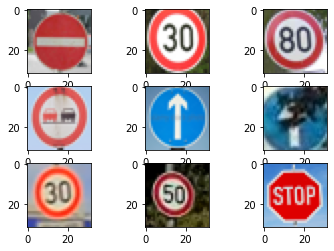

In [14]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import os
import matplotlib.image as mpimg

plt.figure;

N = 9  # number of new testing images
x_test_new = np.zeros((N,32,32,1))

for i in range(N):
    j = i + 1
    image_name = os.path.join("images/", str(j) + ".png")
    image = cv2.imread(image_name)
    image_enchanced = grayAndEqualizeHist(image)
    x_test_new[i][:][:][:] = np.array(image_enchanced)[...,np.newaxis]
    
    
    plt.subplot(3,3,j)
    #plt.imshow(image_enchanced, cmap='gray')
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

print('9 new test images')

In [15]:
### Pre-process the new images

# 1. test images are already converted from rgb to grayscale
# x_test_new

# 2. add labels for the new testing images
y_test_new = np.array([17,1,5,9,35,35,1,2,14])

# 3. normalize the data
#x_test_new = np.array([(img - [128.])/128. for img in x_test_new])